In [3]:
import itertools

import matplotlib.pyplot as plt
import numpy as np


def average_sequence(balls) -> int:
    rng = np.random.default_rng()
    s = 0
    for i in itertools.count(1):
        s += balls[rng.integers(0, len(balls))]
        yield int(100 * s / i)


def simulation(days: int, iterations: int, balls: list[int]):
    res = np.zeros((1201, days), dtype=int)
    
    for _ in range(iterations):
        average = average_sequence(balls)
        for d in range(days):
            a = next(average)
            res[a][d] += 1
            
    return res


def numbers_to_averages(ns: list[int]):
    res = np.empty(len(ns))
    s = 0
    for i, n in enumerate(ns):
        s += n
        res[i] = s / (i + 1)
    return res


def fraction_that_far(sim, val, day):
    delta = abs(int(val * 100) - 550)
    day_values = sim[:,day]    
    total = sum(day_values)
    good = sum(day_values[550 + delta:])  + sum(day_values[0:550 - delta])
    return good / total


def probabilities(sim, averages, skip=0):
    res = np.empty(len(averages))
    
    for i, a in enumerate(averages):
        res[i] = 100 * fraction_that_far(sim, a, i + 1 + skip)
    
    return res


def char_to_int(ch: str) -> int:
    n = int(ch)
    return 10 if n == 0 else n
    

def read_numbers(path: str) -> list[int]:
    with open(path) as f:
        data = f.read()
    return list(map(char_to_int, data))

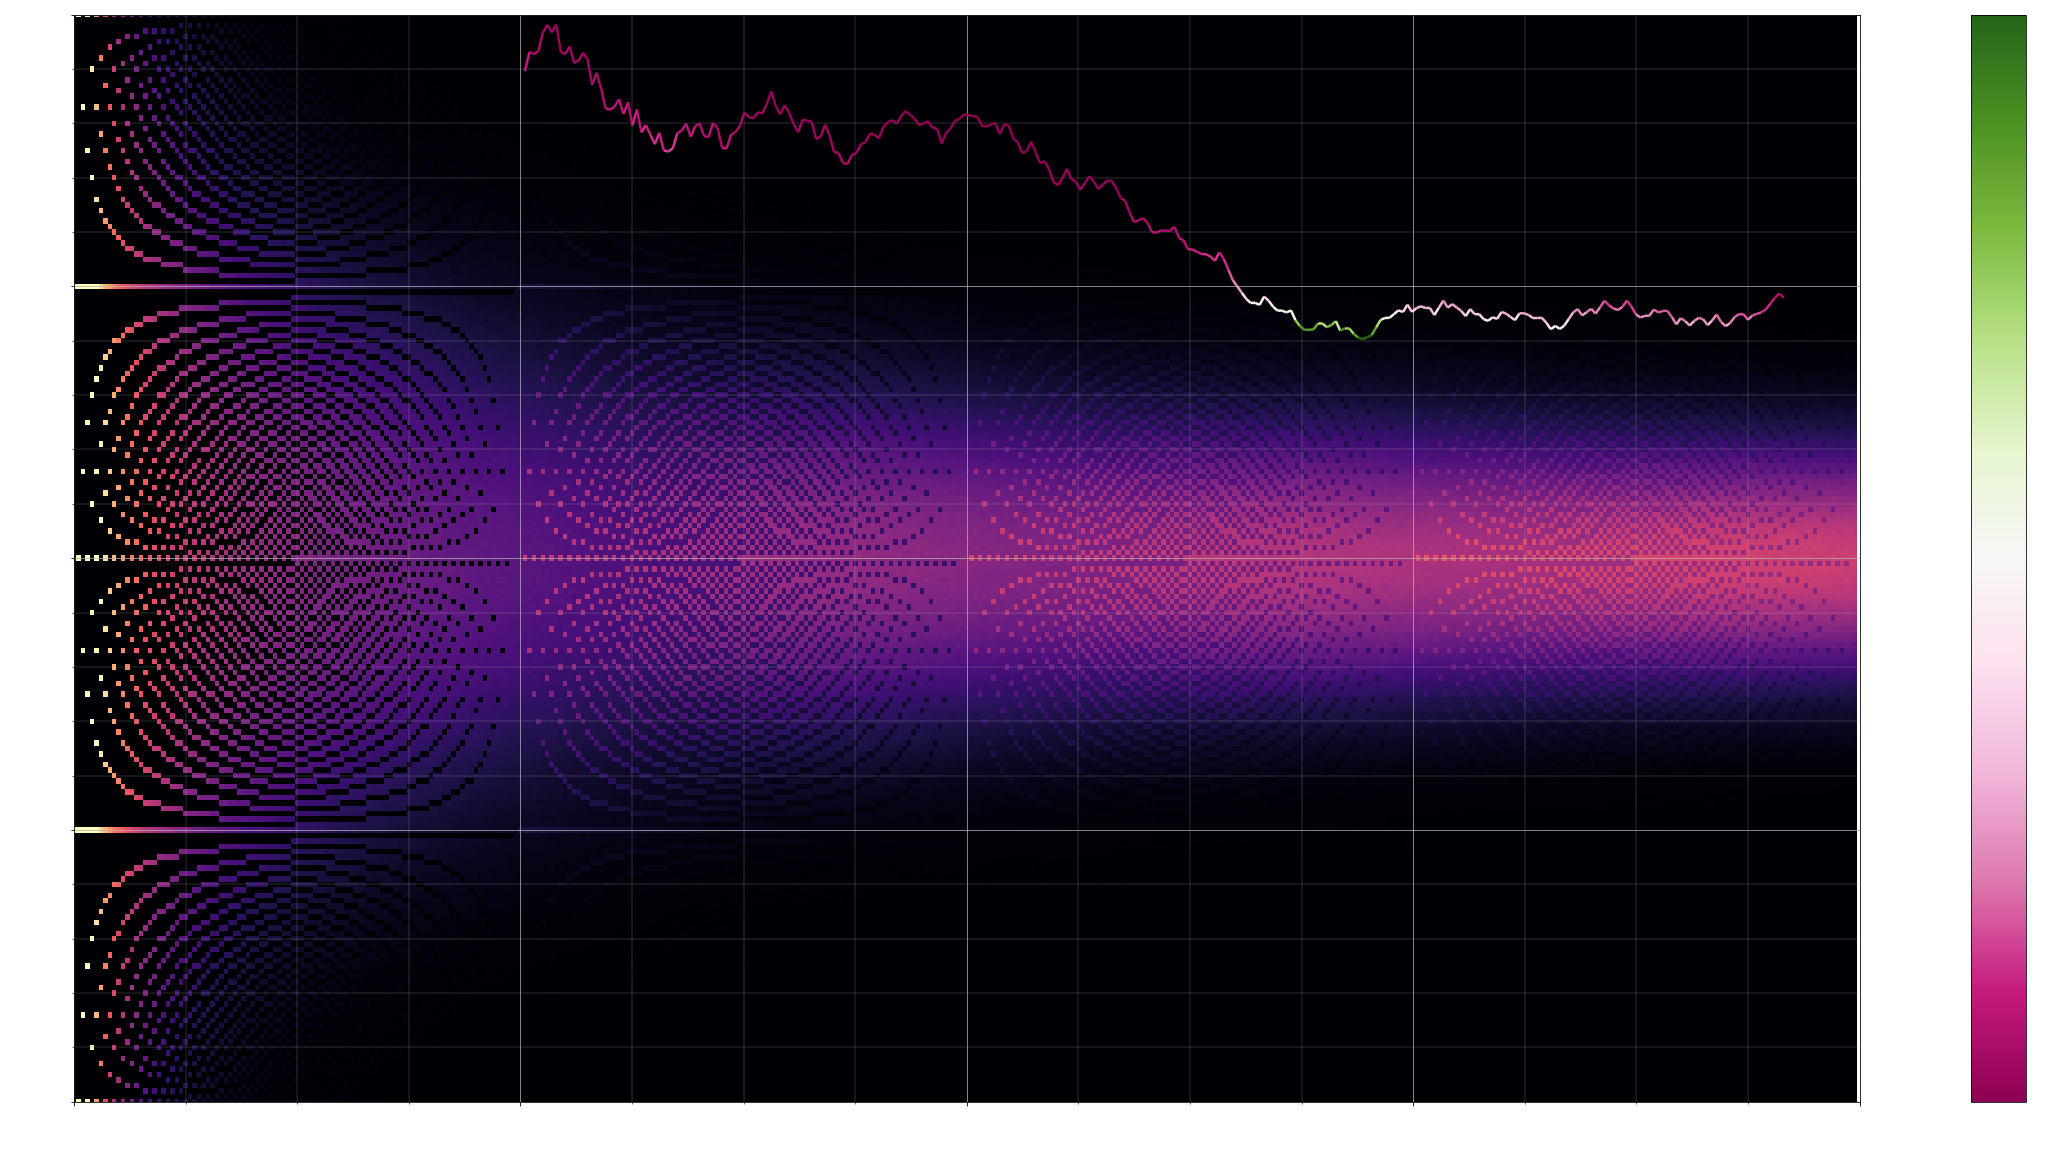

In [5]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from multiprocessing import Pool, cpu_count
from matplotlib.collections import LineCollection
from pathlib import Path

DAYS = 400
ITERS = 250_000
BALLS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cpus = cpu_count()

with Pool(processes=cpus) as pool:
    work = [(DAYS, ITERS // cpus, BALLS)] * cpus
    data = sum(pool.starmap(simulation, work))

SKIP=100
NUMBERS = read_numbers("data.txt")
AVERAGES = numbers_to_averages(NUMBERS)[SKIP:]
X = np.linspace(1 + SKIP, len(AVERAGES) + 1 + SKIP, len(AVERAGES))
Z = probabilities(data, AVERAGES, SKIP)

fig, ax = plt.subplots(figsize=(40, 20))

max_val = data.max()
cmap="magma"
text_color = "white"

im = ax.pcolormesh(
    np.arange(0, DAYS, 1),
    np.arange(0, 12.01, 0.01), 
    data, cmap=cmap, shading="auto", vmin=0, vmax=max_val / 2)

points = np.array([X, AVERAGES]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

norm = plt.Normalize(Z.min(), Z.max())
lc = LineCollection(segments, cmap='PiYG', norm=norm)
lc.set_array(Z)
lc.set_linewidth(2.5)
line = ax.add_collection(lc)

cb = fig.colorbar(line, ax=ax)
cb.ax.yaxis.set_tick_params(color=text_color)
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=text_color)

ax.set_xlim([0, DAYS])
ax.set_ylim([4.50, 6.50])

plt.ylabel("average", fontsize=24, color=text_color)
plt.xlabel("days", fontsize=24, color=text_color)

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

plt.yticks(fontsize=20, color=text_color)
plt.xticks(fontsize=20, color=text_color)

ax.grid(which="major", axis="both", linestyle="-", linewidth=0.75)
ax.grid(which="minor", axis="both", linestyle="-", linewidth=0.25)

plt.show()

image_path="./images"
Path(image_path).mkdir(exist_ok=True)
fig.savefig(f"{image_path}/average_{DAYS}d_{ITERS}i_{cmap}_{text_color}.png", facecolor="black")